# Setup

In [8]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from datetime import datetime
import noisereduce as nr
import soundfile as sf
from scipy.io import wavfile
from scipy.io.wavfile import write
import scipy.signal as signal
import scipy.io.wavfile as wav
from IPython.display import Audio
import functions as func
import pickle
from scipy.signal import find_peaks
import sys

In [9]:
template = np.loadtxt("bit_sound.txt", delimiter=",")  # Adjust delimiter as needed
template_high_pass = func.high_pass_filter(template, 48000, cutoff=2048, order= 5)

## Example

c:\Users\dror.e\AppData\Local\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


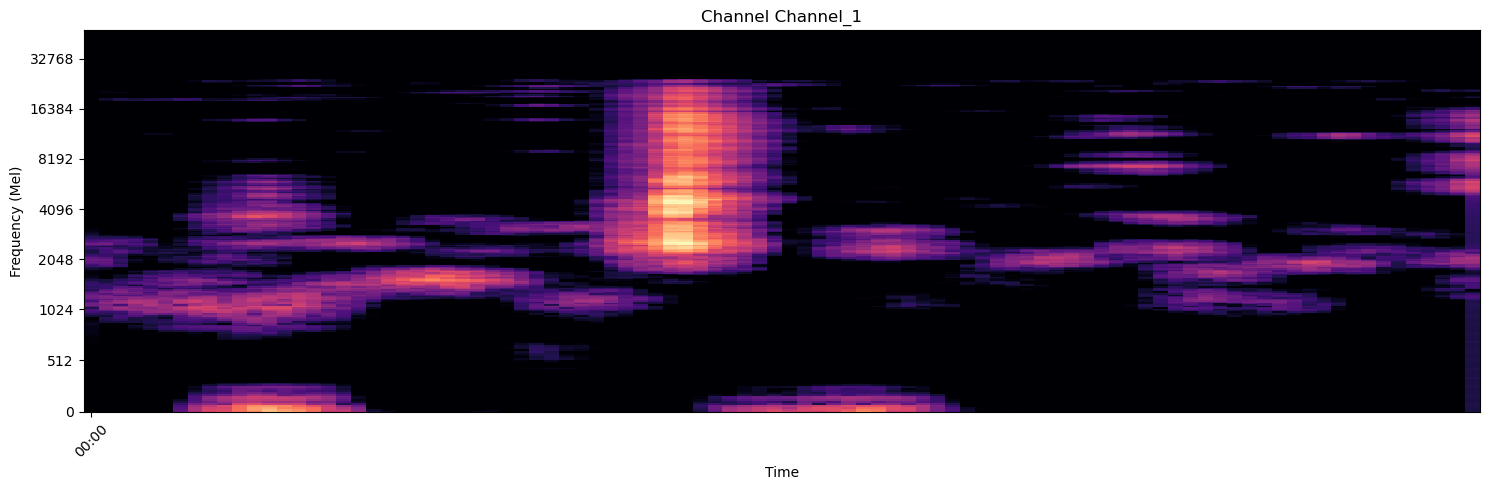

In [50]:
func.plot_spectrogram_or_mel(template,48000, mel=True)

c:\Users\dror.e\AppData\Local\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


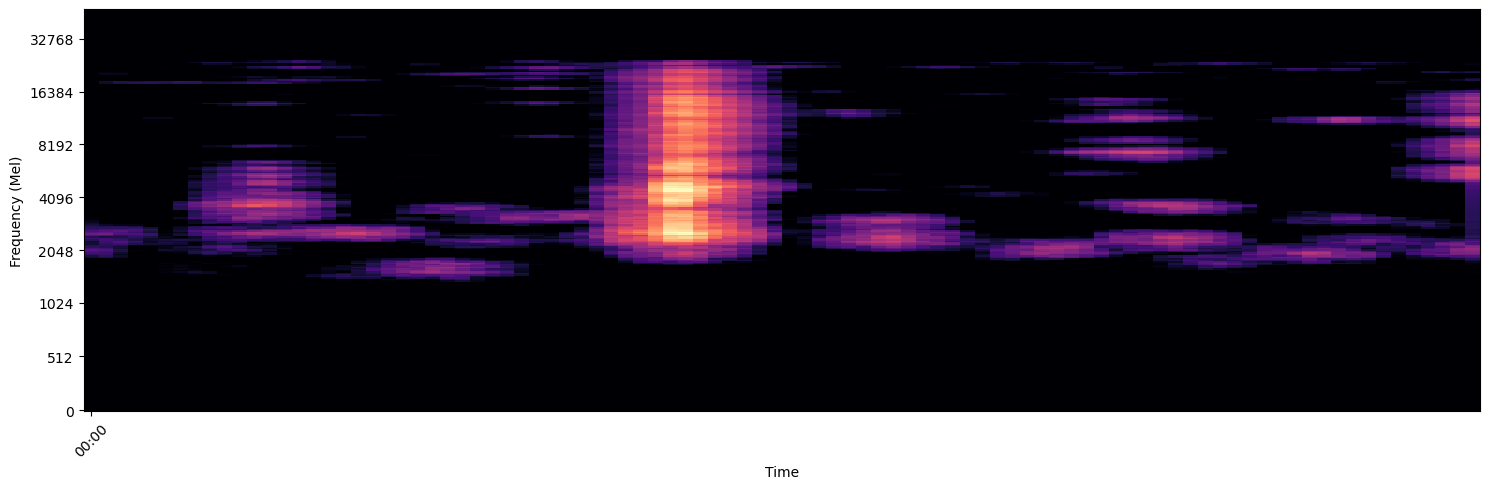

In [20]:
func.plot_spectrogram_or_mel(template_high_pass,48000, mel=True)

Steps for Matched Filter:
1. template and signal in fft
2. conjugate the fft of the template (it's like time reversing in the time domain)
3. Multiply the conjugated FFT of the template with the FFT of the signal (cross-correlation)
4. Take the inverse FFT (IFFT) to return to the time domain

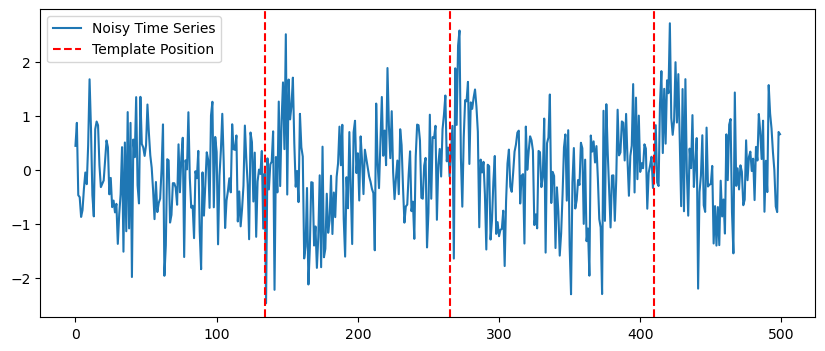

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def generate_noisy_series(template, series_length, noise_factor):
    time_series = np.zeros(series_length)
    template_length = len(template)
    
    # Insert the template three times at random locations
    positions = np.sort(np.random.choice(series_length - template_length, 3, replace=False))
    for pos in positions:
        time_series[pos:pos + template_length] += template
    
    # Add noise proportional to the template's magnitude
    noise = noise_factor * np.max(template) * np.random.randn(series_length)
    time_series += noise
    
    return time_series, positions

# Example usage
template = np.sin(np.linspace(0, 2 * np.pi, 50))  # Example template
series_length = 500
noise_factor = 0.8  # Adjust noise level

time_series, positions = generate_noisy_series(template, series_length, noise_factor)

# Plot the result
plt.figure(figsize=(10, 4))
plt.plot(time_series, label='Noisy Time Series')
for pos in positions:
    plt.axvline(pos, color='r', linestyle='--', label='Template Position' if pos == positions[0] else "")
plt.legend()
plt.show()


In [16]:
# Apply matched filtering
result, mag, angle, threshold, peaks = matched_filter(time_series, template)

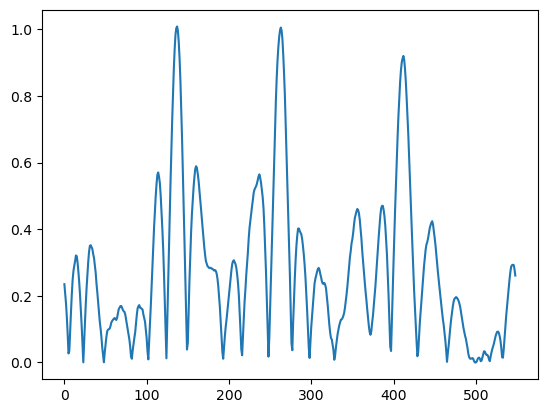

In [17]:
plt.plot(mag)

In [7]:
%reset -f

# Run matched

In [10]:
path = r"C:\Users\dror.e\Documents\wav_files\combined_audio_241030_T9_T10.wav"
sample_rate, data = wavfile.read(path)

In [11]:
time_series_reduce_noise = {}
for i in range(0, 6):
    time_series_reduce_noise[i]= func.reduce_noise(data[:, i], sample_rate)

# Convert all arrays in the dictionary to float
time_series_reduce_noise = {key: np.array(value, dtype=float) for key, value in time_series_reduce_noise.items()}

In [12]:
# Get the file name after the last slash
file_name = os.path.basename(path)

In [13]:
# Get the part before the last dot (file name without extension)
name_without_extension, _ = os.path.splitext(file_name)

In [14]:
# Save to a pickle file
new_filename = f"{name_without_extension}_noise_reduce.pkl"
with open(new_filename, "wb") as f:
    pickle.dump(time_series_reduce_noise, f)

In [5]:
# Load pickle file
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

# Example usage
file_path = r"C:\Users\dror.e\Documents\241030-T1112_noise_reduce.pkl"  # Replace with your file path
time_series_reduce_noise = load_pickle(file_path)

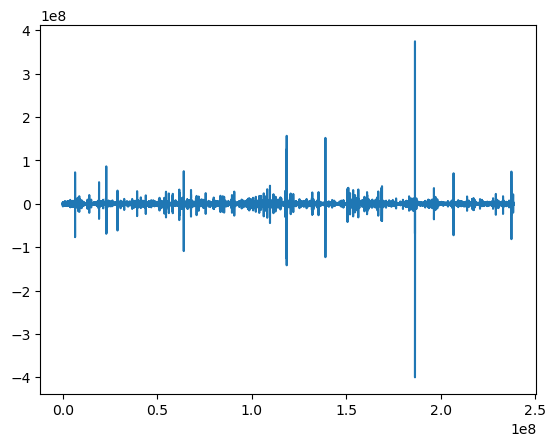

In [15]:
plt.plot(time_series_reduce_noise[0])

c:\Users\dror.e\AppData\Local\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


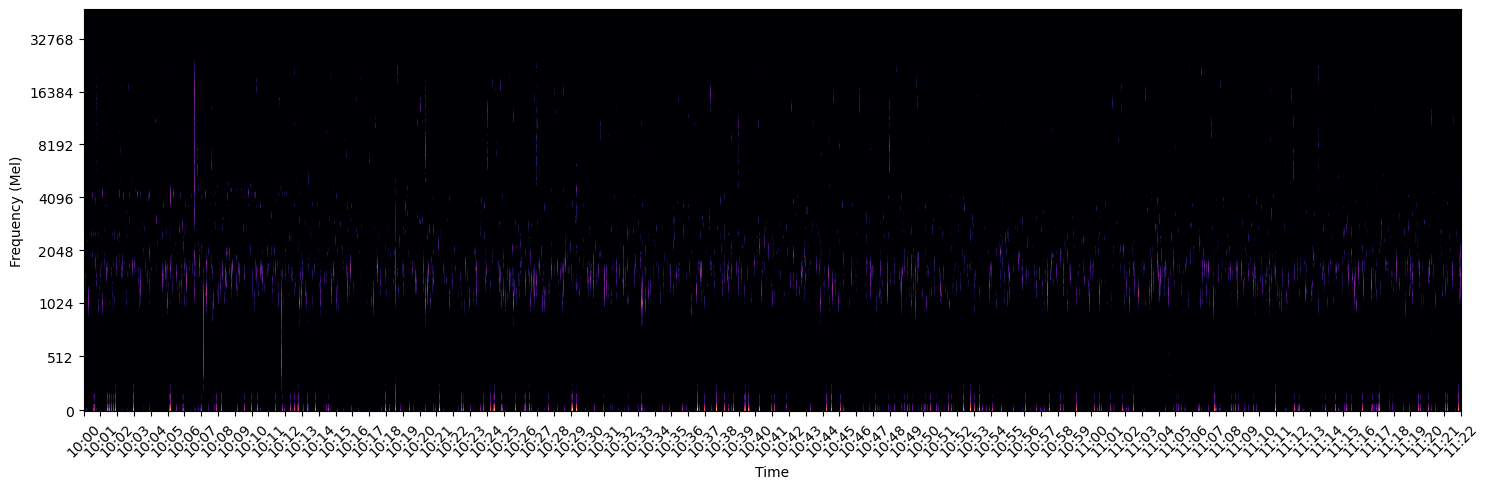

In [56]:
# Define the time strings
time_start_str = "11/07/2024  10:00:00 AM"
time_end_str = "11/07/2024  10:41:10 AM"
# Define the format
time_format = "%m/%d/%Y %I:%M:%S %p"

# Convert to datetime objects
time_start = datetime.strptime(time_start_str, time_format)
time_end = datetime.strptime(time_end_str, time_format)

func.plot_spectrogram_or_mel(time_series_reduce_noise[0], 48000,start_time=time_start, end_time= time_end, mel=True)


c:\Users\dror.e\AppData\Local\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


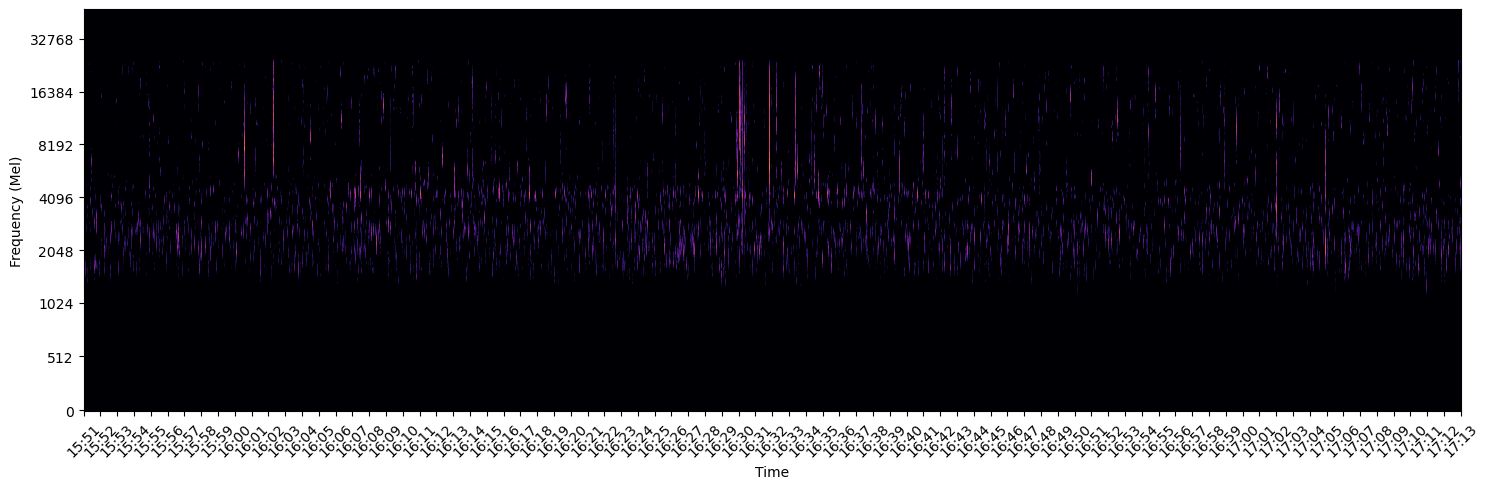

In [19]:
func.plot_spectrogram_or_mel(high_pass_combined, 48000,start_time=time_start, end_time= time_end, mel=True)


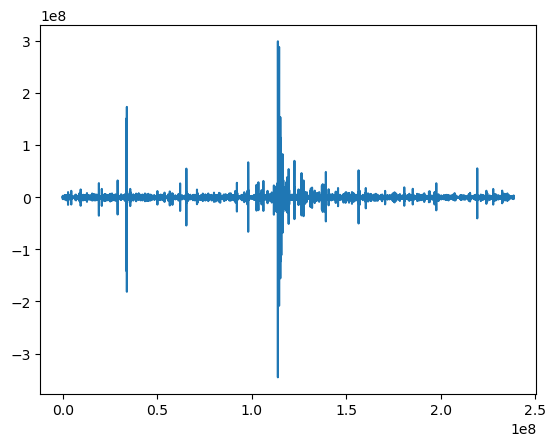

In [12]:
plt.plot(time_series_reduce_noise[0])

In [16]:
sample_rate = 48000
high_pass_combined = func.high_pass_filter(time_series_reduce_noise[0], sample_rate, cutoff=2048, order=5)

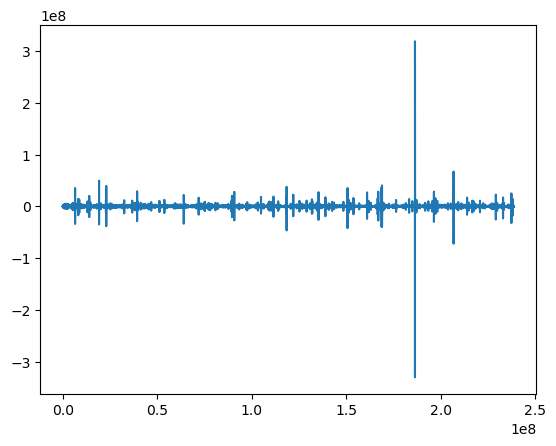

In [58]:
plt.plot(high_pass_combined)

In [18]:
def matched_filter(signal, template, threshold_factor=3.0):
    signal = np.asarray(signal)
    template = np.asarray(template)

    N, M = len(signal), len(template)

    L = N + M - 1  

    signal_fft = np.fft.fft(signal, L)  # Implicit zero-padding
    template_fft = np.fft.fft(template, L)
    result = np.fft.ifft(signal_fft * np.conjugate(template_fft))

    energy = np.sum(np.abs(template)**2)
    if energy:
        result /= energy

    mag = np.abs(result)
    noise_std = np.std(mag)  # noise estimate
    threshold = threshold_factor * noise_std
    #peaks, _ = find_peaks(mag, height=threshold)

    return result, mag, threshold

In [19]:
result, mag, threshold = matched_filter(high_pass_combined, template_high_pass)

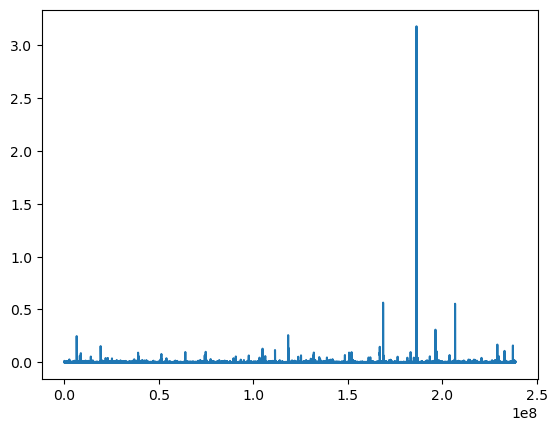

In [20]:
plt.plot(mag)

# Combined WAV

In [ ]:
def combine_wav_files(wav1_path, wav2_path, output_path):
    # Open the first WAV file
    with wave.open(wav1_path, 'rb') as wav1, wave.open(wav2_path, 'rb') as wav2:
        # Ensure both WAV files have the same parameters
        if wav1.getparams() != wav2.getparams():
            raise ValueError("WAV files must have the same sample width, frame rate, and channels")

        # Open output WAV file
        with wave.open(output_path, 'wb') as output_wav:
            output_wav.setparams(wav1.getparams())

            # Chunk size for reading (to avoid memory issues)
            chunk_size = 1024 * 1024  # 1MB chunks

            # Copy data from first WAV file
            while True:
                data = wav1.readframes(chunk_size)
                if not data:
                    break
                output_wav.writeframes(data)

            # Copy data from second WAV file
            while True:
                data = wav2.readframes(chunk_size)
                if not data:
                    break
                output_wav.writeframes(data)

    print(f"Combined file saved at: {output_path}")

# Example usage
wav1_path = r'C:\Users\dror.e\Documents\wav_files\241030-T006.WAV'
wav2_path = r'C:\Users\dror.e\Documents\wav_files\241030-T007.WAV'
output_path = "combined_audio.wav"

combine_wav_files(wav1_path, wav2_path, output_path)

# Analyzing Combined WAV

In [7]:
path = r'C:\Users\dror.e\Documents\combined_audio.wav'
sample_rate, data_combined = wavfile.read(path)

In [8]:
time_series_reduce_noise= func.reduce_noise(data_combined[:, 0], sample_rate)

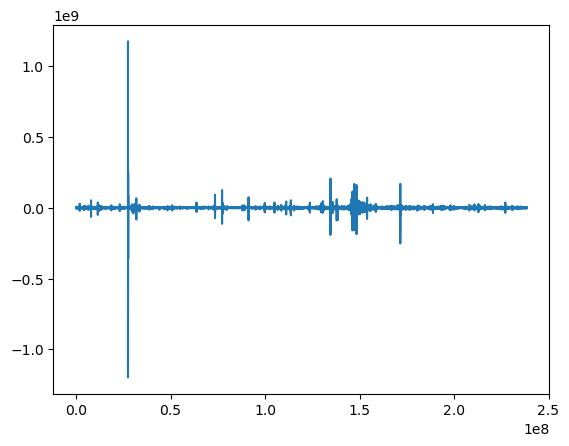

In [9]:
plt.plot(time_series_reduce_noise)

# Aplling high pass to the combined

In [11]:
high_pass_combined = high_pass_filter(time_series_reduce_noise, sample_rate, cutoff=2048)

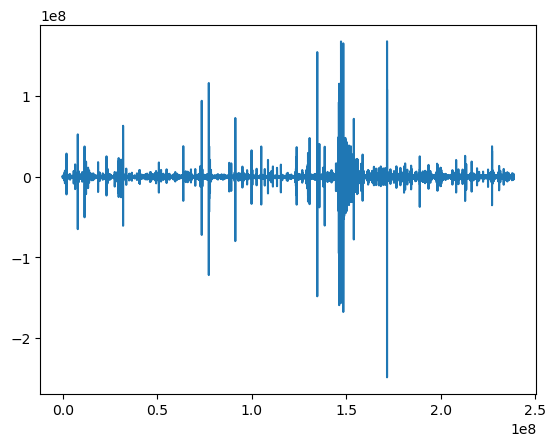

In [12]:
plt.plot(high_pass_combined)

## High pass the template

In [17]:
high_pass_template = high_pass_filter(template, sample_rate, cutoff=2048)

In [18]:
c_result, c_mag, c_angle, c_threshold, c_peaks = matched_filter(high_pass_combined, high_pass_template)

In [ ]:
plt.plot(c_result)

In [20]:
c_threshold

0.004998608875184394

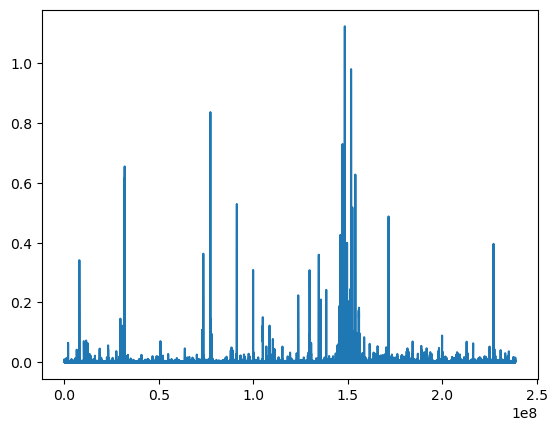

In [19]:
plt.plot(c_mag)

# Cuting outliner

In [21]:
path = r'C:\Users\dror.e\Documents\wav_files\241030-T006.WAV'
sample_rate, outliner_data = wavfile.read(path)

C:\Users\dror.e\AppData\Local\Temp\ipykernel_11844\1427116265.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, outliner_data = wavfile.read(path)


In [22]:
outliner_data = outliner_data.astype(float)

In [23]:
reduced_outliner = func.reduce_noise(outliner_data[:,0], sr=sample_rate)

In [24]:
t6_highpass = high_pass_filter(reduced_outliner, sample_rate)

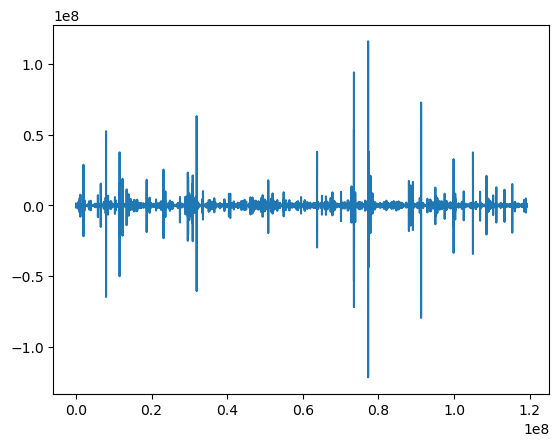

In [25]:
plt.plot(t6_highpass)

In [26]:
result_6, mag_6, angle_6, threshold_6, peaks_6 = matched_filter(t6_highpass,high_pass_template)

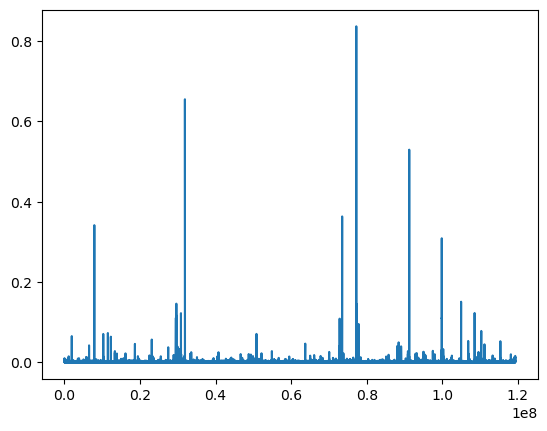

In [27]:
plt.plot(mag_6)

c:\Users\dror.e\AppData\Local\anaconda3\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


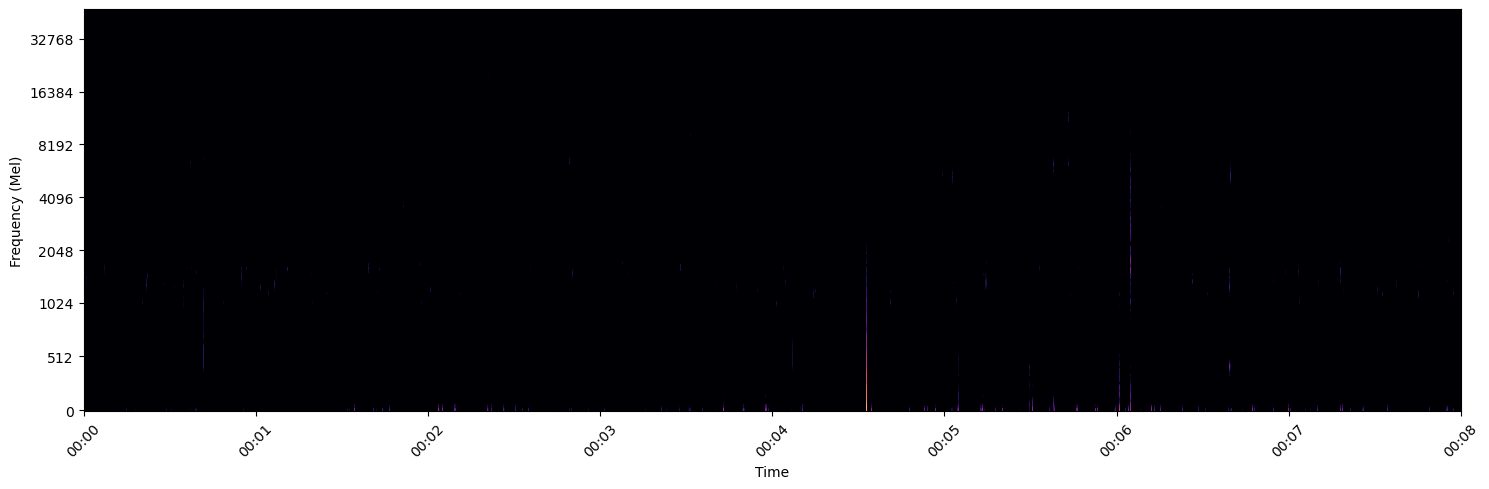

In [54]:
plot_spectrogram_or_mel(reduced_outliner, sample_rate, mel = True, start_min=5, end_min=13)

In [40]:
outliner_result, outliner_mag, outliner_angle, outliner_threshold, outliner_peaks = matched_filter(reduced_outliner, template)

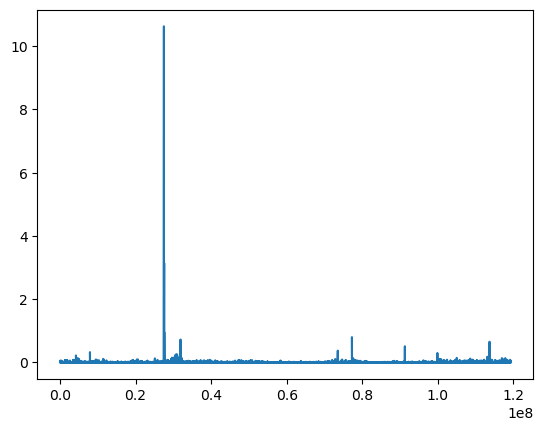

In [41]:
plt.plot(outliner_mag)

# Apply high pass

In [10]:
import scipy.signal as signal
import numpy as np

def high_pass_filter(y, sr, cutoff=2048, order=5):
    """
    Apply a high-pass Butterworth filter to remove frequencies below a given cutoff.

    Parameters:
    - y: Input audio signal (numpy array)
    - sr: Sampling rate (Hz)
    - cutoff: Cutoff frequency (Hz) - Default is 2048 Hz
    - order: Filter order - Default is 5 (higher order gives a sharper cutoff)

    Returns:
    - Filtered signal (numpy array)
    """
    nyquist = 0.5 * sr  # Nyquist frequency (half of sampling rate)
    normal_cutoff = cutoff / nyquist  # Normalize cutoff frequency (0 to 1 range)
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_y = signal.filtfilt(b, a, y)  # Apply the filter forward & backward
    return filtered_y


In [56]:
filtered_signal = high_pass_filter(reduced_outliner, sample_rate, cutoff=2048)

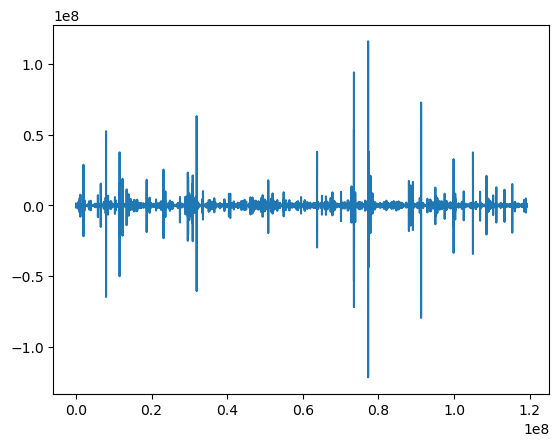

In [57]:
plt.plot(filtered_signal)

In [58]:
high_pass_combined = high_pass_filter(data_combined[:, 0], sample_rate, cutoff=2048)

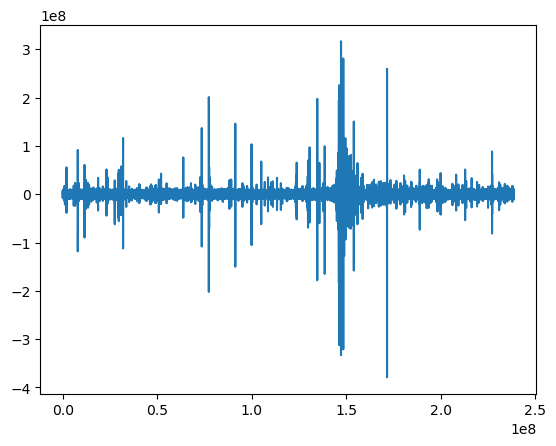

In [59]:
plt.plot(high_pass_combined)

# Energy Graph

In [21]:
def process_array(arr, threshold, sampling_rate):
    """
    Processes an array by applying a threshold, squaring values above it, and summing them within a sliding window.
    
    Parameters:
        arr (numpy array): Input array of numerical values.
        threshold (float): Threshold value.
        sampling_rate (int): Number of samples per second (default: 1 Hz).
        
    Returns:
        numpy array: Array of summed squared values for each window.
    """
    window_size = 10 * 60 * sampling_rate  # 10-minute window size
    step_size = 1 * 60 * sampling_rate  # 1-minute step size
    num_windows = (len(arr) - window_size) // step_size + 1  # Number of sliding windows
    
    result = np.zeros(num_windows)
    
    for i in range(num_windows):
        start = i * step_size
        window = arr[start:start + window_size]
        squared_values = np.where(window > threshold, window**2, 0)  # Square values above threshold
        result[i] = np.sum(squared_values)  # Sum all squared values
    
    return result

In [22]:
#threshold = c_threshold
processed_arr = process_array(mag, threshold, sampling_rate=sample_rate)

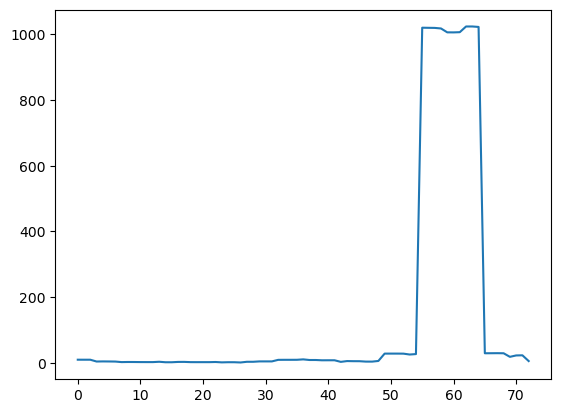

In [23]:
plt.plot(processed_arr)